# ICA-FFT Approach
This is the implementation of FFT based ICA method for automatic removal of EOG artifacts in EEG signal

In [1]:
import csv
import copy
import time

import numpy as np
import scipy
from scipy import signal
from scipy.fftpack import fft
from scipy.stats.stats import pearsonr
from sklearn.decomposition import FastICA
import matplotlib.pyplot as plt

In [2]:
# Name of csv file
left_csv = ['left-1-01.12.16.10.54.50', 'left-10-01.12.16.10.58.55', 'left-2-01.12.16.10.55.15',
           'left-3-01.12.16.10.55.37', 'left-4-01.12.16.10.56.00', 'left-5-01.12.16.10.56.28',
           'left-6-01.12.16.10.56.55', 'left-7-01.12.16.10.57.25', 'left-8-01.12.16.10.58.01', 
            'left-9-01.12.16.10.58.35']

right_csv = ['right-1-01.12.16.10.59.27', 'right-10-01.12.16.11.03.24', 'right-2-01.12.16.10.59.48',
            'right-3-01.12.16.11.00.13', 'right-4-01.12.16.11.00.38', 'right-5-01.12.16.11.01.02',
            'right-6-01.12.16.11.01.32', 'right-7-01.12.16.11.02.02', 'right-8-01.12.16.11.02.32',
            'right-9-01.12.16.11.03.00']

In [3]:
# Parameters for FFt
N = 1280 # the number of data points in the data
fs = 128.0 # sampling rate
T = 1.0/fs # period
freq = np.linspace(0.0, 1.0/(2*T), int(N/2)) # frequency array

## Load data

In [4]:
# Parameters:
#    file_name: file name stored in left_csv/right_csv
# Returns:
#    raw_eeg(mxn ~ 14x1280): A numpy array describing EEG signal, m is the # of sensors and n is # of samples
def load_data(file_name, test_time = 10):
    raw_eeg = []
    i = 0
    
    with open('data/' + file_name + '.csv') as csvfile:
        readcsv = csv.reader(csvfile, delimiter = ',')
        for row in readcsv:
            if i < 2:
                i = i + 1
            else:
                raw_eeg.append(row[2:16])
    
    if test_time == 1:
        raw_eeg = raw_eeg[300:428] # Get 1280 data points or get 10s dataset
    elif test_time == 2:
        raw_eeg = raw_eeg[300:556] # Get 1280 data points or get 10s dataset
    elif test_time == 3:
        raw_eeg = raw_eeg[300:684] # Get 1280 data points or get 10s dataset
    elif test_time == 4:
        raw_eeg = raw_eeg[300:812] # Get 1280 data points or get 10s dataset
    elif test_time == 5:
        raw_eeg = raw_eeg[300:940] # Get 1280 data points or get 10s dataset
    elif test_time == 6:
        raw_eeg = raw_eeg[300:1068] # Get 1280 data points or get 10s dataset
    elif test_time == 7:
        raw_eeg = raw_eeg[300:1196] # Get 1280 data points or get 10s dataset
    elif test_time == 8:
        raw_eeg = raw_eeg[300:1324] # Get 1280 data points or get 10s dataset
    elif test_time == 9:
        raw_eeg = raw_eeg[300:1452] # Get 1280 data points or get 10s dataset
    elif test_time == 10:
        raw_eeg = raw_eeg[300:1580] # Get 1280 data points or get 10s dataset
    
    raw_eeg = np.array(raw_eeg, dtype = float)
    raw_eeg = raw_eeg.T # 14x1280
    
    return raw_eeg

***Example:*** Try plotting EEG data

Shape of the signal
(14, 1280)


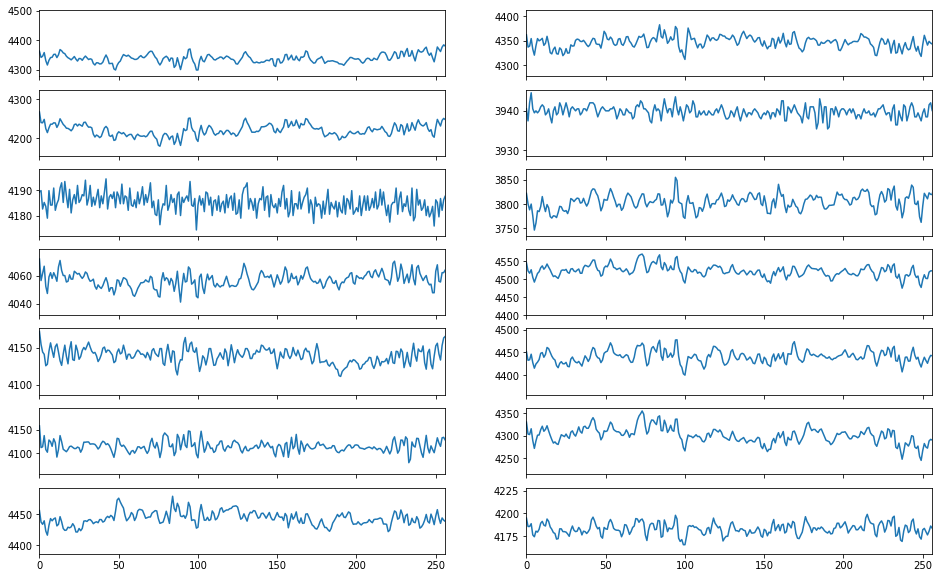

In [5]:
sigs = load_data(left_csv[3])
print("Shape of the signal")
print(sigs.shape)

# Plot data
fig, ax = plt.subplots(7, 2, figsize=(16,10), sharex = True)
for i in range(7):
    for j in range(2):
        ax[i, j].plot(sigs[7*j + i])

ax[0, 0].set_xlim([0, 256])

plt.show()

## Prepare the EEG signal for the experiment
The EEG signal collected from the EPOC device is contaminated by DC offset and noises from electrical source. Thus, to prepare the signal for the experiment, we first use a high pass filter (cutting frequency ~ 0.16 Hz) to remove the DC offset and a Notch filter to remove the noises from electrical sources.

In [6]:
# Parameters: 
#    sigs(mxn ~ 14x1280): signal that is intended to be filtered
#    mode: "bandpass", "highpass" for removing DC offset, "bandstop" for Notch filter
#    low: lower cut-off frequency, default = 0.16 Hz
#    high: higher cut-off frequency, default = 64 Hz
# Returns:
#    fil_signal(mxn ~ 14x1280): signal that has already been filtered
def IIR_filter(sigs, mode, order, low = 0.16, high = 64):
    fil_signal = []
    temp = []
    
    low = low*2.0/128.0
    high = high*2.0/128.0
    
    if mode == "bandstop":
        b, a = scipy.signal.butter(order, [low, high], btype = mode)
    elif mode == "highpass":
        b, a = scipy.signal.butter(order, low, btype = mode)
    elif mode == "lowpass":
        b, a = scipy.signal.butter(order, high, btype = mode)
    
    # Apply IIR filter to signal
    for s in sigs:
        temp = signal.filtfilt(b, a, s)
        fil_signal.append(temp)
    
    fil_signal = np.array(fil_signal, dtype = float)
    
    return fil_signal

***Example:*** Try plotting data after being prefiltered

c:\users\phan nguyen vu (vpi)\appdata\local\programs\python\python35\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


Shape of the signal
(14, 1280)


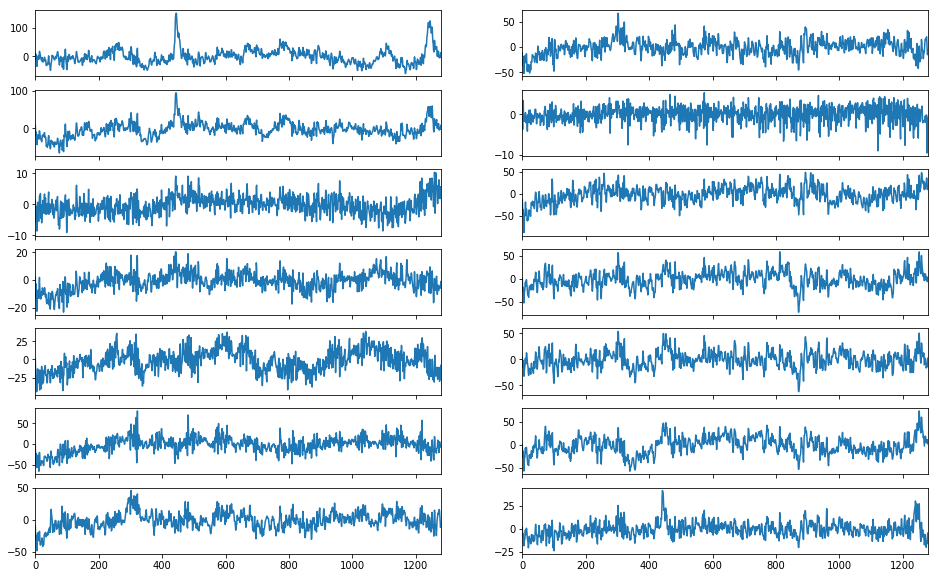

In [7]:
# Remove DC offset
sigs = IIR_filter(sigs, mode = 'highpass', order = 4)
# Remove noises caused by electrical sources
sigs = IIR_filter(sigs, mode = 'bandstop', low = 50, high = 51, order = 4)
print("Shape of the signal")
print(sigs.shape)

# Plot data
fig, ax = plt.subplots(7, 2, figsize=(16,10), sharex = True)
for i in range(7):
    for j in range(2):
        ax[i, j].plot(sigs[7*j + i])

ax[0, 0].set_xlim([0, 1280])

plt.show()


## ICA-FFT 
Implementation of ICA-FFT method

In [8]:
''' ICA part '''
# Parameters:
#    signs(mxn ~ 14x1280): A numpy array of EEG signals
#    n: The number of components that we intend to get
# Returns:
#    S_: Reconstruct signals
#    A_: Estimated mixing matrix
#    ica.mean_: Offset to reconstruct signal
def ica_part(sigs, n):
    sigs = sigs.T #1280x14
    
    ica = FastICA(n_components = n)
    S_ = ica.fit_transform(sigs)  # Reconstruct signals
    S_ = S_.T # 14x1280
    A_ = ica.mixing_ # Get estimated mixing matrix
    
    return S_, A_, ica.mean_

***Experiment:*** Try plotting ICs that construct our signal

c:\users\phan nguyen vu (vpi)\appdata\local\programs\python\python35\lib\site-packages\sklearn\decomposition\fastica_.py:118: UserWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


Shape of the ICs matrix
(14, 1280)


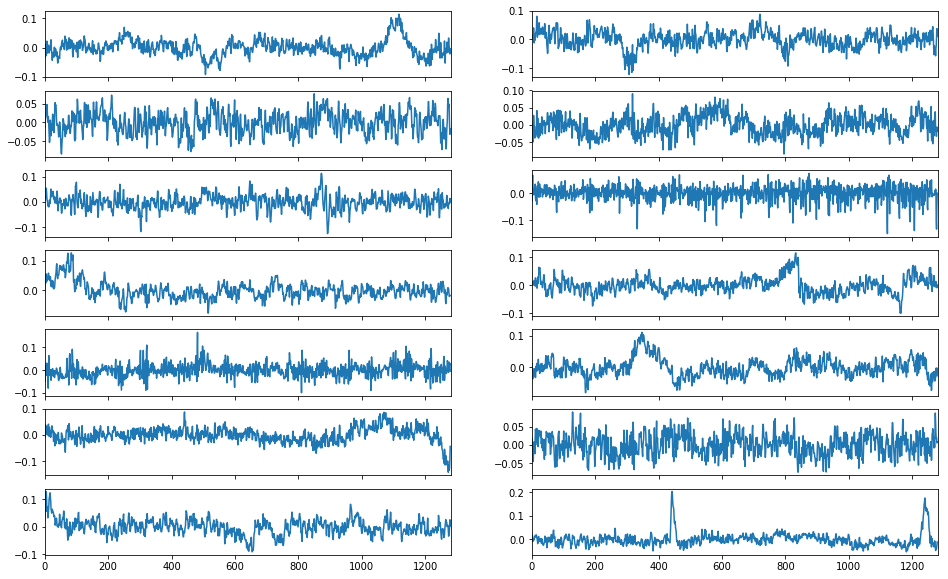

In [9]:
exS, exA, exmean = ica_part(sigs, 14)
print("Shape of the ICs matrix")
print(exS.shape)

# Plot data
fig, ax = plt.subplots(7, 2, figsize=(16,10), sharex = True)
for i in range(7):
    for j in range(2):
        ax[i, j].plot(exS[7*j + i])

ax[0, 0].set_xlim([0, 1280])

plt.show()

In [10]:
''' FFT part '''
# Parameters:
#    icS: 
#    icA:
#    icmean:
# Returns:
#    icA:
def fft_part(icS, icA, thres):
    global N, fs, T, freq
    fft_ics = [] # store the spectra of ICs
    
    for i in range(14):
        fft_ics.append(fft(icS[i])) # apply FFT for the IC
        fft_ics[i] = 40.0/N*np.abs(fft_ics[i][0:int(N/2)])
        # Remove artifacts using threshold
        if (sum(fft_ics[i][0:120])/sum(fft_ics[i][120:300]))>thres:
            icA.T[i] = np.zeros(14)
    
    return icA

In [11]:
# Parameters:
#    sigs (mxn ~ 14x1280): a numpy array of signal that needs to be processed
#    thres: threshold for eliminating noise ICs
#    n: the number of components
# Returns:
#    pro_sigs(mxn ~ 14x1280): a numpy array of signal that is already processed
def ica_fft(sigs, thres, n):
    
    icS, icA, icmean = ica_part(sigs, n)
    icA = fft_part(icS, icA, thres)
    remix_sigs = np.dot(icS.T, icA.T) + icmean # 1280x14
    remix_sigs = remix_sigs.T # 14x1280
    
    return remix_sigs

c:\users\phan nguyen vu (vpi)\appdata\local\programs\python\python35\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


ICA-FFT time execution:  -0.05884265899658203
Comparison between raw EEG and ICA-FFT enhanced EEG
High-pass Butterworth time execution:  -0.0019943714141845703
Comparison between raw EEG and high-pass Butterworth enhanced EEG


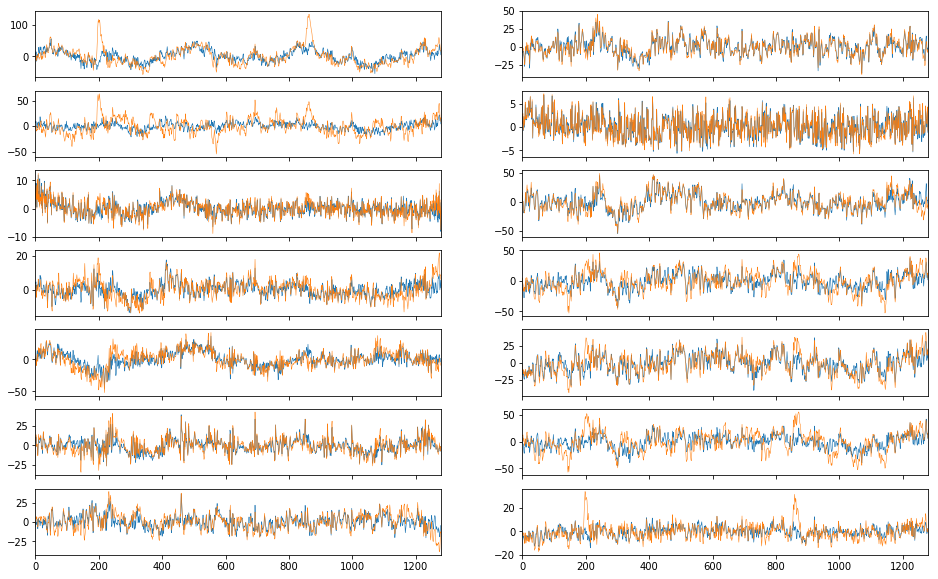

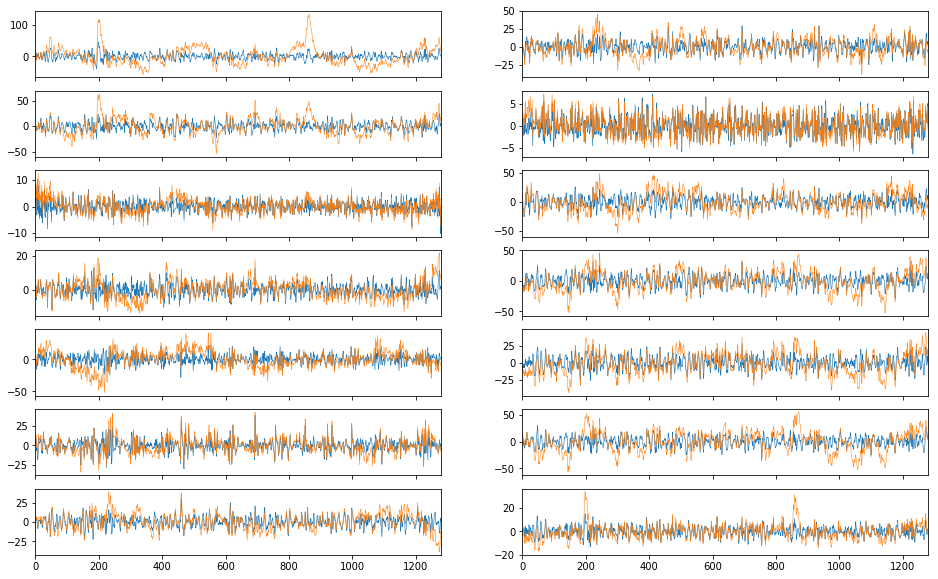

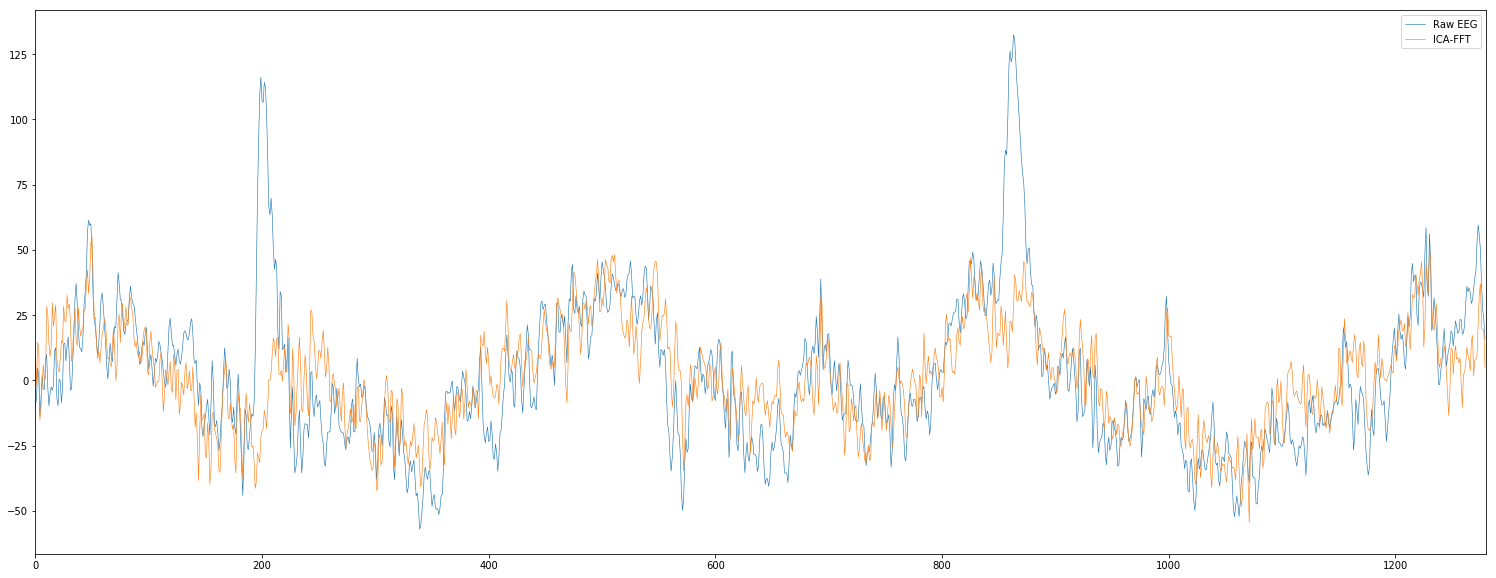

In [35]:
sigs = load_data(right_csv[6])
# Prepare signals for experiment
# Remove DC offset
sigs = IIR_filter(sigs, mode = 'highpass', order = 4)
# Remove noises caused by electrical sources
sigs = IIR_filter(sigs, mode = 'bandstop', low = 50, high = 51, order = 4)

''' ICA-FFT '''
start = 0
end = 0
start = time.time()
ica_results = ica_fft(sigs, 1.9, 14)
end = time.time()
ica_time = start - end
print('ICA-FFT time execution: ', ica_time)
# Plot data
print('Comparison between raw EEG and ICA-FFT enhanced EEG')
fig1, ax1 = plt.subplots(7, 2, figsize=(16,10), sharex = True)
for i in range(7):
    for j in range(2):
        ax1[i, j].plot(ica_results[7*j + i], lw = 0.6)
        ax1[i, j].plot(sigs[7*j + i], lw = 0.5)

ax1[0, 0].set_xlim([0, N])

''' High-pass Butterworth '''
start = 0
end = 0
start = time.time()
high_butt_results = IIR_filter(sigs, mode = 'highpass', order = 4, low = 4)
end = time.time()
high_butt_time = start - end
print('High-pass Butterworth time execution: ', high_butt_time)
print('Comparison between raw EEG and high-pass Butterworth enhanced EEG')
fig2, ax2 = plt.subplots(7, 2, figsize=(16,10), sharex = True)
for i in range(7):
    for j in range(2):
        ax2[i, j].plot(high_butt_results[7*j + i], lw = 0.6)
        ax2[i, j].plot(sigs[7*j + i], lw = 0.5)

ax2[0, 0].set_xlim([0, N])

''' Raw, ICA-FFT, Butterworth '''
fig3, ax3 = plt.subplots(figsize=(26,10), sharex = True)
ax3.plot(sigs[0], lw = 0.6, label = 'Raw EEG')
ax3.plot(ica_results[0], lw = 0.6, label = 'ICA-FFT')
#ax3.plot(high_butt_results[0], lw = 0.9, label = '4Hz high-pass Butterworth')
ax3.legend()
ax3.set_xlim([0, N])

plt.show()

# Peak Detection Algorithm of Independent Component (PDAIC)
Paper: Automatic Removal of Eye-blink Artifacts Based on ICA and peak detection algorithm
Conference: 2nd International Asia Conference on Informatics in Control, Automation and Robotics, 2010

In [13]:
# Parameters: 
#    icS(mxn ~ 14x1280): the reconstruct signal matrix
# Returns:
#    norm_icS(mxn ~ 14x1280): the matrix icS after being normalized
def norm(icS):
    norm_icS = copy.deepcopy(icS)
    for i in range(len(norm_icS)):
        norm_icS[i] = norm_icS[i]/np.max(norm_icS[i])
    
    return norm_icS

***Testing the norm function***

In [14]:
test = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]], dtype = float)
print("Before normalizing")
print(test)
print("After normalizing")
norm_test = norm(test)
print(test)
print(norm_test)

Before normalizing
[[1. 2. 3.]
 [4. 5. 6.]
 [7. 8. 9.]]
After normalizing
[[1. 2. 3.]
 [4. 5. 6.]
 [7. 8. 9.]]
[[0.33333333 0.66666667 1.        ]
 [0.66666667 0.83333333 1.        ]
 [0.77777778 0.88888889 1.        ]]


In [15]:
# Parameters:
#    icA: the estimated mixing matrix
#    icS(mxn ~ 14x1280): the reconstruct signal
#    n: the number of components (ICs)
# Returns:
#    icA: the updating icA matrix
def pdaic(icS, n):
    global N
    
    # Initialize variables
    d1 = 200 # maximum half peak duration
    d2 = 6 # minimum half peak duration
    count = 0 # the value of counter
    L = np.zeros(14) # one head encoding that reflects whether a component is labeled as EBA or not
    
    # Normalize ICs
    norm_icS = norm(icS)
    
    for i in range(n):
        count = 0
        for k in range(round(N/60)): # 60 is the size of a window and 1280 is the total size of the signal
            if np.max(norm_icS[i][(60*k):(60*(k+1)-1)]) > 0.4:
                count = count + 1
        if count >= 6:
            L[i] = 0 # considered as noise
        else:
            extreme_val = 0 # the extreme value point
            extreme_id = 0 # the index of the extreme value point, should be an integer
            zero_id = -1 # the index of the zero point, should be an integer
            d = 0 # distance between zero point and extreme value point
            
            # Find the extreme value point of the left waveform
            extreme_val = np.max(np.abs(icS[i]))
            extreme_id, = np.where(np.abs(icS[i]) == extreme_val)
            extreme_id = extreme_id[0]
            
            ''' Search the left waveform of extreme value point until find a near zero value (0.005) '''
            for j in range(extreme_id, -1, -1):
                if np.abs(icS[i][j]) <= 0.005:
                    zero_id = j
                    break
            
            d = np.abs(extreme_id - zero_id)
            if (zero_id != -1) and (d <= d1) and (d >= d2):
                L[i] = 1
            else:
                ''' Search the right waveform of extreme value point until find a near zero value (0.005) '''
                zero_id = -1 # the index of the zero point, should be an integer
                d = 0 # distance between zero point and extreme value point
                
                for j in range(extreme_id, int(N - 1)):
                    if np.abs(icS[i][j]) <= 0.005:
                        zero_id = j
                        break
                d = np.abs(extreme_id - zero_id)
                if (zero_id != -1) and (d <= d1) and (d >= d2):
                    L[i] = 1
                else:
                    L[i] = 0
                
    return L

Remove artifacts based on the one head encoding L

In [16]:
# Parameters:
#    L: the one head encoding vector that reflects whether the component is EBA or not
#    icA: the estimated mixing matrix
# Returns:
#    icA: The updating icA
def remove_artifact(L, icA):
    for i in range(14): # 14 components
        if L[i] == 1:
            icA.T[i] = np.zeros(14)
        else:
            pass
    
    return icA

In [17]:
# Parameters:
#    sigs(mxn ~ 14x1280): the matrix of EEG signal after beign prefiltered
#    n: the number of components
# Returns:
#    remix_sigs: the reconstructed signal
def peak_detection_ica(sigs, n):
    icS, icA, icmean = ica_part(sigs, n)
    L = pdaic(icS, n) # update the matrix A using the peak detection algorithm
    #print(L)
    icA = remove_artifact(L, icA)
    remix_sigs = np.dot(icS.T, icA.T) + icmean # 1280x14
    remix_sigs = remix_sigs.T # 14x1280
    
    return remix_sigs

***Testing the PDAIC algorithm***

Execution time of PDAIC:  -0.148606538772583
Comparison between raw EEG and PDAIC enhanced EEG


c:\users\phan nguyen vu (vpi)\appdata\local\programs\python\python35\lib\site-packages\sklearn\decomposition\fastica_.py:118: UserWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


(0, 1280)

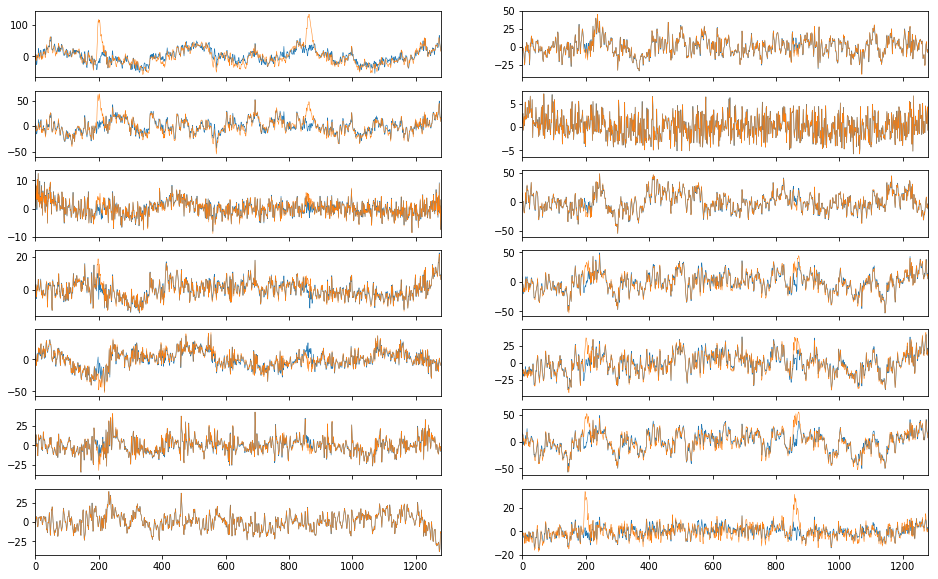

In [18]:
''' Peak detection based ICA '''
start = 0
end = 0
start = time.time()
pdaic_results = peak_detection_ica(sigs, 14)
end = time.time()
pdaic_time = start - end
print('Execution time of PDAIC: ', pdaic_time)
#print(pdaic_results)
# Plot data
print('Comparison between raw EEG and PDAIC enhanced EEG')
fig4, ax4 = plt.subplots(7, 2, figsize=(16,10), sharex = True)
for i in range(7):
    for j in range(2):
        ax4[i, j].plot(pdaic_results[7*j + i], lw = 0.6)
        ax4[i, j].plot(sigs[7*j + i], lw = 0.5)

ax4[0, 0].set_xlim([0, N])

(0, 512)

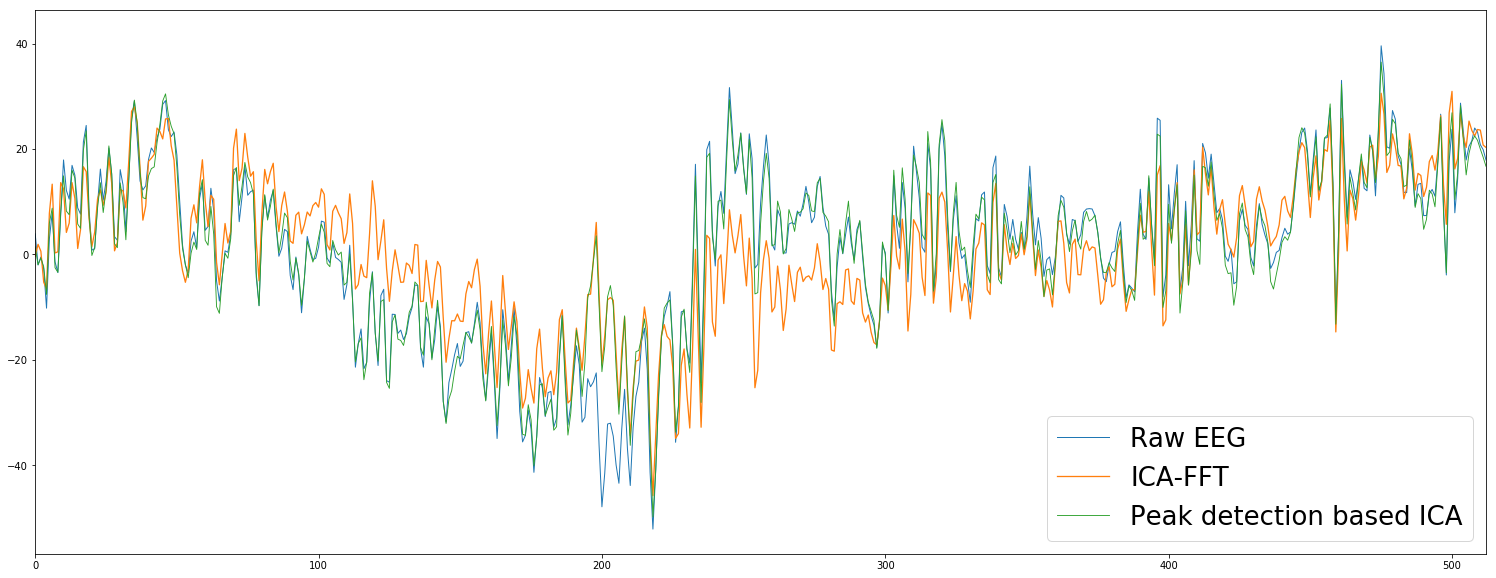

In [19]:
''' Raw, ICA-FFT, PDAIC '''
fig3, ax3 = plt.subplots(figsize=(26,10), sharex = True)
ax3.plot(sigs[4], lw = 1, label = 'Raw EEG')
ax3.plot(ica_results[4], lw = 1.3, label = 'ICA-FFT')
ax3.plot(pdaic_results[4], lw = 0.9, label = 'Peak detection based ICA')
#ax3.plot(high_butt_results[0], lw = 0.9, label = '4Hz high-pass Butterworth')
ax3.legend(prop={'size': 26})
ax3.set_xlim([0, 512])

# Plot some results

## 1. Raw EEG vs. our proposed scheme

(0, 512)

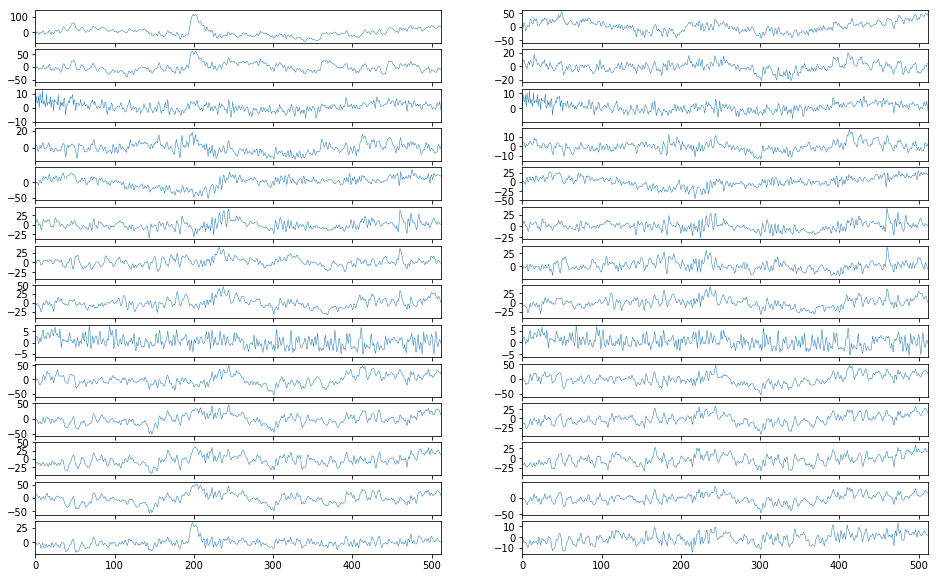

In [20]:
fig7, ax7 = plt.subplots(14, 2, figsize=(16,10), sharex = True)
for i in range(14):
    ax7[i, 0].plot(sigs[i], lw = 0.5)
    ax7[i, 1].plot(ica_results[i], lw = 0.5)

ax7[0, 0].set_xlim([0, 512])

## 2. ICs that can be removed
Using the old results

## 3. Compare our proposed scheme vs. high-pass Butterworth
In terms of information

(0, 512)

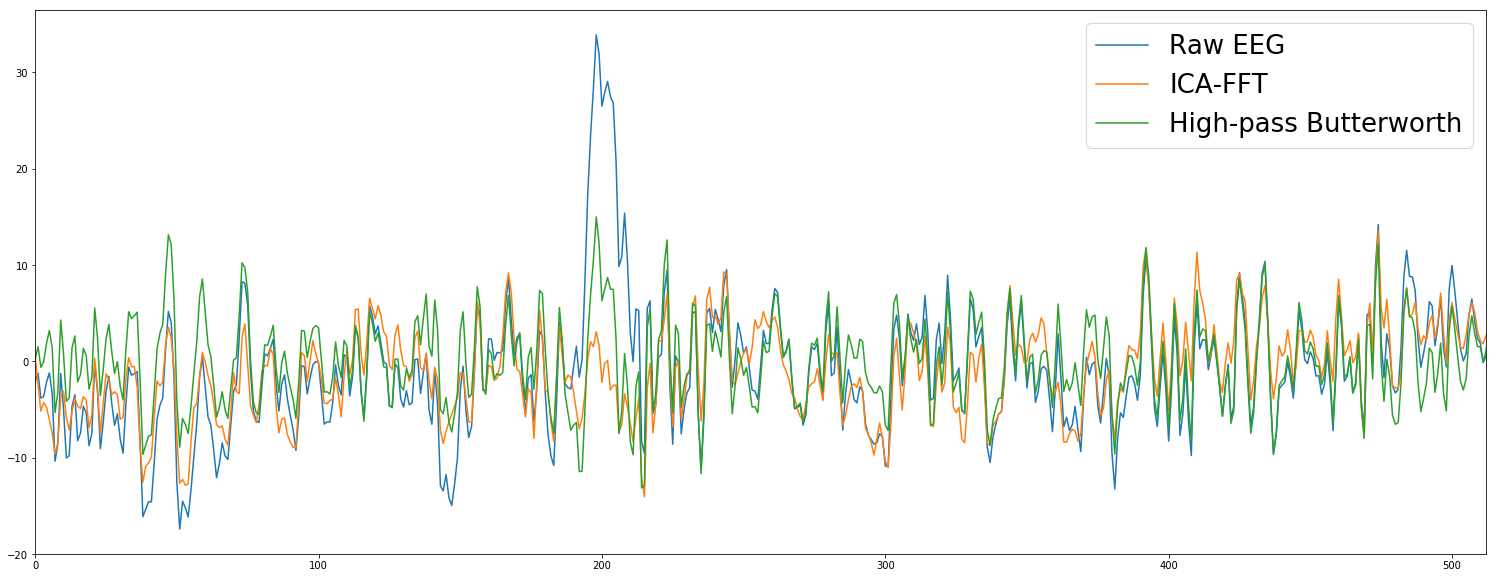

In [21]:
fig3, ax3 = plt.subplots(figsize=(26,10), sharex = True)
ax3.plot(sigs[13], lw = 1.5, label = 'Raw EEG')
ax3.plot(ica_results[13], lw = 1.5, label = 'ICA-FFT')
ax3.plot(high_butt_results[13], lw = 1.5, label = 'High-pass Butterworth')
#ax3.plot(high_butt_results[0], lw = 0.9, label = '4Hz high-pass Butterworth')
ax3.legend(prop={'size': 26})
ax3.set_xlim([0, 512])

(450, 700)

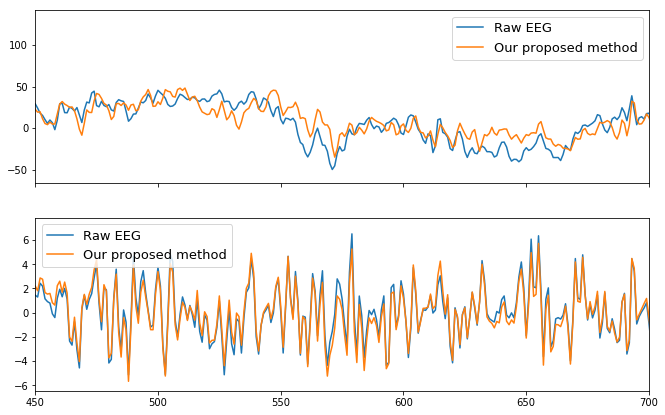

In [22]:
fig3, ax3 = plt.subplots(2, 1, figsize=(11,7), sharex = True)
ax3[0].plot(sigs[0], lw = 1.5, label = 'Raw EEG')
ax3[0].plot(ica_results[0], lw = 1.5, label = 'Our proposed method')
ax3[1].plot(sigs[8], lw = 1.5, label = 'Raw EEG')
ax3[1].plot(ica_results[8], lw = 1.5, label = 'Our proposed method')
#ax3.plot(high_butt_results[0], lw = 0.9, label = '4Hz high-pass Butterworth')
ax3[0].legend(prop={'size': 13})
ax3[1].legend(prop={'size': 13})
ax3[0].set_xlim([450, 700])

## Compare our proposed scheme vs. PDAIC
### Robust
Correlation coefficient plot

In terms of performance

(0, 300)

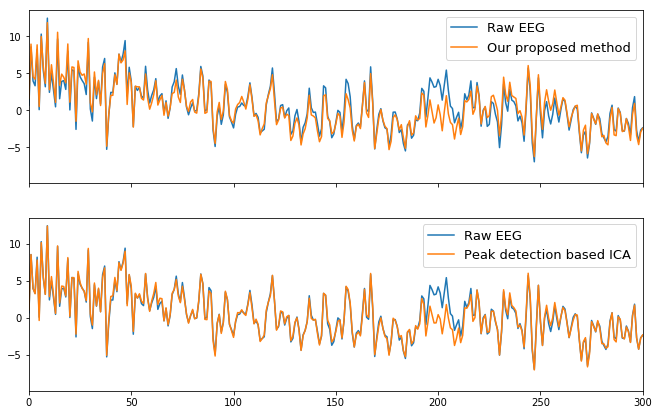

In [23]:
fig10, ax10 = plt.subplots(2, 1, figsize=(11,7), sharex = True)
ax10[0].plot(sigs[2], lw = 1.5, label = 'Raw EEG')
ax10[0].plot(ica_results[2], lw = 1.5, label = 'Our proposed method')
ax10[1].plot(sigs[2], lw = 1.5, label = 'Raw EEG')
ax10[1].plot(pdaic_results[2], lw = 1.5, label = 'Peak detection based ICA')
#ax3.plot(high_butt_results[0], lw = 0.9, label = '4Hz high-pass Butterworth')
ax10[0].legend(prop={'size': 13})
ax10[1].legend(prop={'size': 13})
ax10[0].set_xlim([0, 300])

### Running time 
According to the size of the window

In [24]:
''' Proposed scheme '''
ica_1280_runtime = []
for i in range(30):
    ica_time = 0
    start = 0
    end = 0
    start = time.time()
    ica_results = ica_fft(sigs, 1.9, 14)
    end = time.time()
    ica_time = end - start
    ica_1280_runtime.append(ica_time)
''' PDAIC '''
pdaic_1280_runtime = []
for j in range(30):
    pdaic_time = 0
    start = 0
    end = 0
    start = time.time()
    pdaic_results = peak_detection_ica(sigs, 14)
    end = time.time()
    pdaic_time = end - start
    pdaic_1280_runtime.append(pdaic_time)

print('ICA-FFT runtime (10s window)')
print(ica_1280_runtime)
print(np.mean(ica_1280_runtime))
print()
print('PDAIC runtime (10s window)')
print(pdaic_1280_runtime)
print(np.mean(pdaic_1280_runtime))

c:\users\phan nguyen vu (vpi)\appdata\local\programs\python\python35\lib\site-packages\sklearn\decomposition\fastica_.py:118: UserWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


ICA-FFT runtime (10s window)
[0.1436171531677246, 0.07679462432861328, 0.0857706069946289, 0.13863348960876465, 0.13464021682739258, 0.13463973999023438, 0.13463997840881348, 0.13763189315795898, 0.11170125007629395, 0.13463973999023438, 0.1396632194519043, 0.10471987724304199, 0.1436161994934082, 0.14162111282348633, 0.14162135124206543, 0.14461326599121094, 0.05485391616821289, 0.14162087440490723, 0.1436154842376709, 0.14241337776184082, 0.07451701164245605, 0.1406240463256836, 0.1406238079071045, 0.14162135124206543, 0.13962674140930176, 0.1406242847442627, 0.139113187789917, 0.04986691474914551, 0.14058995246887207, 0.06781864166259766]
0.12353644371032715

PDAIC runtime (10s window)
[0.1406238079071045, 0.1436159610748291, 0.14274263381958008, 0.13962721824645996, 0.1406238079071045, 0.1406240463256836, 0.10671496391296387, 0.1406235694885254, 0.14162158966064453, 0.08477354049682617, 0.08975982666015625, 0.1406238079071045, 0.14662480354309082, 0.04287838935852051, 0.13862919807

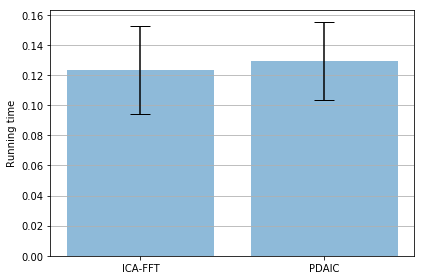

In [25]:
ica_1280_runtime = np.array(ica_1280_runtime)
pdaic_1280_runtime = np.array(pdaic_1280_runtime)

# Create Arrays for the plot
materials = ['ICA-FFT', 'PDAIC']
x_pos = np.arange(len(materials))
CTEs = [np.mean(ica_1280_runtime), np.mean(pdaic_1280_runtime)]
error = [np.std(ica_1280_runtime), np.std(pdaic_1280_runtime)]
# Build the plot
fig, ax = plt.subplots()
ax.bar(x_pos, CTEs, yerr=error, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Running time')
ax.set_xticks(x_pos)
ax.set_xticklabels(materials)
#ax.set_title('Coefficent of Thermal Expansion (CTE) of Three Metals')
ax.yaxis.grid(True)

# Save the figure and show
plt.tight_layout()
plt.savefig('bar_plot_with_error_bars.png')
plt.show()

In [26]:
for test in range(10, -1, -1):
    print(test)
a = np.array([7, -9, 6, -7, 8])
ex = np.max(np.abs(a))
ex_id = np.where(np.abs(a) == ex)
print(ex)
print(ex_id[0][0])

10
9
8
7
6
5
4
3
2
1
0
9
1


### Correlation Coefficient

In [27]:
# Params:
#    mode: 'butt', 'pdaic', 'ica-fft'
# Returns:
#    cc(mxn): a numpy array that stores correlation coefficient, m = # of sensor, n = # of cc
def get_cc(mode):
    cc1 = []
    cc2 = []
    cc3 = []
    cc4 = []
    cc5 = []
    cc6 = []
    cc7 = []
    cc8 = []
    cc9 = []
    cc10 = []
    cc11 = []
    cc12 = []
    cc13 = []
    cc14 = []
    for n_sample in range(0, 10, 1):
        #print('\n TURN %d \n' %n_sample)
                
        ''' Load data '''
        cc_sigs = load_data(right_csv[n_sample])
        
        ''' Prepare signals for experiment '''
        # Remove DC offset
        cc_sigs = IIR_filter(cc_sigs, mode = 'highpass', order = 4)
        # Remove noises caused by electrical sources
        cc_sigs = IIR_filter(cc_sigs, mode = 'bandstop', low = 50, high = 51, order = 4)
        
        ''' Apply method '''
        if mode == 'butt':
            processed_sigs = IIR_filter(cc_sigs, mode = 'highpass', order = 4, low = 4)
        elif mode == 'pdaic':
            processed_sigs = peak_detection_ica(cc_sigs, 14)
        elif mode == 'ica-fft':
            processed_sigs = ica_fft(cc_sigs, 1.9, 14)
        
        cc1.append(pearsonr(cc_sigs[0], processed_sigs[0])[0])
        cc2.append(pearsonr(cc_sigs[1], processed_sigs[1])[0])
        cc3.append(pearsonr(cc_sigs[2], processed_sigs[2])[0])
        cc4.append(pearsonr(cc_sigs[3], processed_sigs[3])[0])
        cc5.append(pearsonr(cc_sigs[4], processed_sigs[4])[0])
        cc6.append(pearsonr(cc_sigs[5], processed_sigs[5])[0])
        cc7.append(pearsonr(cc_sigs[6], processed_sigs[6])[0])
        cc8.append(pearsonr(cc_sigs[7], processed_sigs[7])[0])
        cc9.append(pearsonr(cc_sigs[8], processed_sigs[8])[0])
        cc10.append(pearsonr(cc_sigs[9], processed_sigs[9])[0])
        cc11.append(pearsonr(cc_sigs[10], processed_sigs[10])[0])
        cc12.append(pearsonr(cc_sigs[11], processed_sigs[11])[0])
        cc13.append(pearsonr(cc_sigs[12], processed_sigs[12])[0])
        cc14.append(pearsonr(cc_sigs[13], processed_sigs[13])[0])
    
    for n_sample in range(0, 10, 1):
        #print('\n TURN %d \n' %n_sample)
                
        ''' Load data '''
        cc_sigs = load_data(left_csv[n_sample])
        
        ''' Prepare signals for experiment '''
        # Remove DC offset
        cc_sigs = IIR_filter(cc_sigs, mode = 'highpass', order = 4)
        # Remove noises caused by electrical sources
        cc_sigs = IIR_filter(cc_sigs, mode = 'bandstop', low = 50, high = 51, order = 4)
        
        ''' Apply method '''
        if mode == 'butt':
            processed_sigs = IIR_filter(cc_sigs, mode = 'highpass', order = 4, low = 4)
        elif mode == 'pdaic':
            processed_sigs = peak_detection_ica(cc_sigs, 14)
        elif mode == 'ica-fft':
            processed_sigs = ica_fft(cc_sigs, 1.9, 14)
        
        cc1.append(pearsonr(cc_sigs[0], processed_sigs[0])[0])
        cc2.append(pearsonr(cc_sigs[1], processed_sigs[1])[0])
        cc3.append(pearsonr(cc_sigs[2], processed_sigs[2])[0])
        cc4.append(pearsonr(cc_sigs[3], processed_sigs[3])[0])
        cc5.append(pearsonr(cc_sigs[4], processed_sigs[4])[0])
        cc6.append(pearsonr(cc_sigs[5], processed_sigs[5])[0])
        cc7.append(pearsonr(cc_sigs[6], processed_sigs[6])[0])
        cc8.append(pearsonr(cc_sigs[7], processed_sigs[7])[0])
        cc9.append(pearsonr(cc_sigs[8], processed_sigs[8])[0])
        cc10.append(pearsonr(cc_sigs[9], processed_sigs[9])[0])
        cc11.append(pearsonr(cc_sigs[10], processed_sigs[10])[0])
        cc12.append(pearsonr(cc_sigs[11], processed_sigs[11])[0])
        cc13.append(pearsonr(cc_sigs[12], processed_sigs[12])[0])
        cc14.append(pearsonr(cc_sigs[13], processed_sigs[13])[0])
    
    return [cc1, cc2, cc3, cc4, cc5, cc6, cc7, cc8, cc9, cc10, cc11, cc12, cc13, cc14]

In [28]:
'''
butt_plot = get_cc(mode = 'butt')
pdaic_plot = get_cc(mode = 'pdaic')
ica_plot = get_cc(mode = 'ica-fft')

fig33, ax33 = plt.subplots(1, 3, figsize=(30,10), sharex = True)
ax33[0].boxplot(butt_plot, 0, '')
ax33[1].boxplot(pdaic_plot, 0, '')
ax33[2].boxplot(ica_plot, 0, '')

plt.show()
'''

"\nbutt_plot = get_cc(mode = 'butt')\npdaic_plot = get_cc(mode = 'pdaic')\nica_plot = get_cc(mode = 'ica-fft')\n\nfig33, ax33 = plt.subplots(1, 3, figsize=(30,10), sharex = True)\nax33[0].boxplot(butt_plot, 0, '')\nax33[1].boxplot(pdaic_plot, 0, '')\nax33[2].boxplot(ica_plot, 0, '')\n\nplt.show()\n"

c:\users\phan nguyen vu (vpi)\appdata\local\programs\python\python35\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
c:\users\phan nguyen vu (vpi)\appdata\local\programs\python\python35\lib\site-packages\sklearn\decomposition\fastica_.py:118: UserWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


[0.58573384 0.73762567 0.9589657  0.92747504 0.93631107 0.96394244
 0.96894346 0.95922553 0.99264852 0.96030188 0.85746048 0.8478404
 0.82612859 0.84470758]


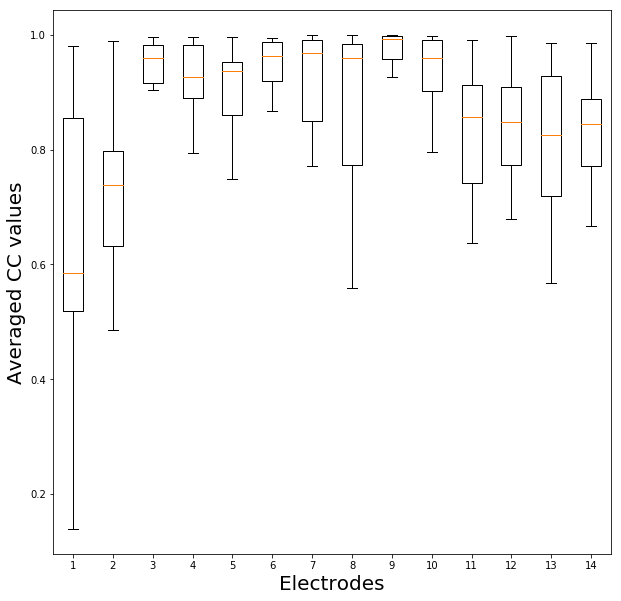

In [29]:
ica_plot = get_cc(mode = 'ica-fft')
print(np.median(ica_plot, axis = 1))

fig34, ax34 = plt.subplots(figsize=(10,10), sharex = True)
ax34.boxplot(ica_plot, 0, '')
ax34.set_ylabel('Averaged CC values', fontsize = 20)
ax34.set_xlabel('Electrodes', fontsize = 20)

plt.show()

### $R^2$ Ratio
The higher value of $R^2$ means that the proposed algorithms are more accurate <br>
[1] *Study on Performance Metrics for Consideration of Efficiency of the Ocular Artifact Removal Algorithms for EEG Signals*, 2015

In [30]:
# Params:
#    raw: a numpy array of raw signal
#    new: a numpy array of processed signal
# Returns:
#    r_square: the r square (scalar)
def r_square_calculation(raw, new):
    r_square = 0
    
    # Calculate numerator
    numerator = raw - new
    numerator = numerator**2
    numerator = np.sum(numerator)
    
    # Calculate denominator
    denominator = new**2
    denominator = np.sum(denominator)
    
    r_square = numerator/denominator
    
    return r_square

In [31]:
# Params:
#    mode: 'butt', 'pdaic', 'ica-fft'
# Returns:
#    cc(mxn): a numpy array that stores correlation coefficient, m = # of sensor, n = # of cc
def get_r_square(mode):
    cc1 = []
    cc2 = []
    cc3 = []
    cc4 = []
    cc5 = []
    cc6 = []
    cc7 = []
    cc8 = []
    cc9 = []
    cc10 = []
    cc11 = []
    cc12 = []
    cc13 = []
    cc14 = []
    for n_sample in range(0, 10, 1):
        #print('\n TURN %d \n' %n_sample)
                
        ''' Load data '''
        cc_sigs = load_data(right_csv[n_sample])
        
        ''' Prepare signals for experiment '''
        # Remove DC offset
        cc_sigs = IIR_filter(cc_sigs, mode = 'highpass', order = 4)
        # Remove noises caused by electrical sources
        cc_sigs = IIR_filter(cc_sigs, mode = 'bandstop', low = 50, high = 51, order = 4)
        
        ''' Apply method '''
        if mode == 'butt':
            processed_sigs = IIR_filter(cc_sigs, mode = 'highpass', order = 4, low = 4)
        elif mode == 'pdaic':
            processed_sigs = peak_detection_ica(cc_sigs, 14)
        elif mode == 'ica-fft':
            processed_sigs = ica_fft(cc_sigs, 1.9, 14)
        
        cc1.append(r_square_calculation(cc_sigs[0], processed_sigs[0]))
        cc2.append(r_square_calculation(cc_sigs[1], processed_sigs[1]))
        cc3.append(r_square_calculation(cc_sigs[2], processed_sigs[2]))
        cc4.append(r_square_calculation(cc_sigs[3], processed_sigs[3]))
        cc5.append(r_square_calculation(cc_sigs[4], processed_sigs[4]))
        cc6.append(r_square_calculation(cc_sigs[5], processed_sigs[5]))
        cc7.append(r_square_calculation(cc_sigs[6], processed_sigs[6]))
        cc8.append(r_square_calculation(cc_sigs[7], processed_sigs[7]))
        cc9.append(r_square_calculation(cc_sigs[8], processed_sigs[8]))
        cc10.append(r_square_calculation(cc_sigs[9], processed_sigs[9]))
        cc11.append(r_square_calculation(cc_sigs[10], processed_sigs[10]))
        cc12.append(r_square_calculation(cc_sigs[11], processed_sigs[11]))
        cc13.append(r_square_calculation(cc_sigs[12], processed_sigs[12]))
        cc14.append(r_square_calculation(cc_sigs[13], processed_sigs[13]))
    
    for n_sample in range(0, 10, 1):
        #print('\n TURN %d \n' %n_sample)
                
        ''' Load data '''
        cc_sigs = load_data(left_csv[n_sample])
        
        ''' Prepare signals for experiment '''
        # Remove DC offset
        cc_sigs = IIR_filter(cc_sigs, mode = 'highpass', order = 4)
        # Remove noises caused by electrical sources
        cc_sigs = IIR_filter(cc_sigs, mode = 'bandstop', low = 50, high = 51, order = 4)
        
        ''' Apply method '''
        if mode == 'butt':
            processed_sigs = IIR_filter(cc_sigs, mode = 'highpass', order = 4, low = 4)
        elif mode == 'pdaic':
            processed_sigs = peak_detection_ica(cc_sigs, 14)
        elif mode == 'ica-fft':
            processed_sigs = ica_fft(cc_sigs, 1.9, 14)
        
        cc1.append(r_square_calculation(cc_sigs[0], processed_sigs[0]))
        cc2.append(r_square_calculation(cc_sigs[1], processed_sigs[1]))
        cc3.append(r_square_calculation(cc_sigs[2], processed_sigs[2]))
        cc4.append(r_square_calculation(cc_sigs[3], processed_sigs[3]))
        cc5.append(r_square_calculation(cc_sigs[4], processed_sigs[4]))
        cc6.append(r_square_calculation(cc_sigs[5], processed_sigs[5]))
        cc7.append(r_square_calculation(cc_sigs[6], processed_sigs[6]))
        cc8.append(r_square_calculation(cc_sigs[7], processed_sigs[7]))
        cc9.append(r_square_calculation(cc_sigs[8], processed_sigs[8]))
        cc10.append(r_square_calculation(cc_sigs[9], processed_sigs[9]))
        cc11.append(r_square_calculation(cc_sigs[10], processed_sigs[10]))
        cc12.append(r_square_calculation(cc_sigs[11], processed_sigs[11]))
        cc13.append(r_square_calculation(cc_sigs[12], processed_sigs[12]))
        cc14.append(r_square_calculation(cc_sigs[13], processed_sigs[13]))
    
    return [cc1, cc2, cc3, cc4, cc5, cc6, cc7, cc8, cc9, cc10, cc11, cc12, cc13, cc14]

In [32]:
'''
butt_plot = get_r_square(mode = 'butt')
pdaic_plot = get_r_square(mode = 'pdaic')
ica_plot = get_r_square(mode = 'ica-fft')

plt.plot(np.mean(butt_plot, axis = 1), label = 'Butterworth')
plt.plot(np.mean(pdaic_plot, axis = 1), label = 'PDAIC')
plt.plot(np.mean(ica_plot, axis = 1), label = 'ICA-FFT')
plt.legend()
plt.show()
'''

"\nbutt_plot = get_r_square(mode = 'butt')\npdaic_plot = get_r_square(mode = 'pdaic')\nica_plot = get_r_square(mode = 'ica-fft')\n\nplt.plot(np.mean(butt_plot, axis = 1), label = 'Butterworth')\nplt.plot(np.mean(pdaic_plot, axis = 1), label = 'PDAIC')\nplt.plot(np.mean(ica_plot, axis = 1), label = 'ICA-FFT')\nplt.legend()\nplt.show()\n"

In [33]:
pdaic_plot = get_r_square(mode = 'pdaic')
ica_plot = get_r_square(mode = 'ica-fft')

c:\users\phan nguyen vu (vpi)\appdata\local\programs\python\python35\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
c:\users\phan nguyen vu (vpi)\appdata\local\programs\python\python35\lib\site-packages\sklearn\decomposition\fastica_.py:118: UserWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


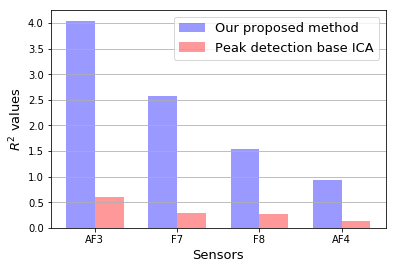

In [34]:
n_groups = 4

ica_plot_frontal = [ica_plot[0], ica_plot[1], ica_plot[12], ica_plot[13]]
pdaic_plot_frontal = [pdaic_plot[0], pdaic_plot[1], pdaic_plot[12], pdaic_plot[13]]

# Get the mean of R square of our proposed and PDAIC
mean_proposed = np.mean(ica_plot_frontal, axis = 1)

mean_pdaic = np.mean(pdaic_plot_frontal, axis = 1)

# Plot bar chart
fig99, ax99 = plt.subplots(figsize=(6,4))
index = np.arange(n_groups)
bar_width = 0.35

opacity = 0.4
error_config = {'ecolor': '0.3'}

rects1 = ax99.bar(index, mean_proposed, bar_width,
                alpha=opacity, color='b',
                label='Our proposed method')

rects2 = ax99.bar(index + bar_width, mean_pdaic, bar_width,
                alpha=opacity, color='r',
                label='Peak detection base ICA')

ax99.set_xlabel('Sensors', fontsize = 13)
ax99.set_ylabel(r'$R^2$ values', fontsize = 13)
#ax99.set_title('Scores by group and gender')
ax99.set_xticks(index + bar_width / 2)
ax99.set_xticklabels(['AF3', 'F7', 'F8', 'AF4'])
ax99.legend(prop={'size': 13})
ax99.yaxis.grid(True)
plt.savefig('r_square_comparison_pdaic_vs_proposed.png')

#fig99.tight_layout()
plt.show()